$$ y(t) = g(t) + s(t) + h(t) + \epsilon_t $$
where $g$ is trend, $s$ is seasonality, $h$ is other regressors, $\epsilon$ is error.

The linear trend is $$ \left(k+A\delta\right)t + \left(m+A\left(-s\delta\right)\right)$$

Seasonality is $$ s\left(t\right) = \sum_{n=1}^N \left( a_n \cos \frac{2\pi n t}{p} + b_n \sin \frac{2\pi n t}{p} \right) $$

In [1]:
import pandas as pd 
import numpy as np
import pymc3 as pm 
import theano.tensor as tt
import matplotlib.pyplot as plt

In [2]:
bd = pd.read_csv('./birthdates.csv')

lam_date_join = lambda row: f"{row['year']}-{row['month']}-{row['day']}"
bd["date"] = pd.to_datetime(bd.apply(lam_date_join, axis=1), format="%Y-%m-%d")

lam_get_day = lambda date: date.days

bd_sm = bd[bd["year"] <= 1970]
bd_sm['date_indexed'] = (bd_sm['date'] - bd_sm['date'].min()).apply(lam_get_day)
# bd_sm['date_normed'] = (bd_sm['date_indexed'] - bd_sm['date_indexed'].mean()) / bd_sm['date_indexed'].std()
bd_sm['births_normed'] = (bd_sm['births'] - bd_sm['births'].mean()) / bd_sm['births'].std()

# date_scale = 1/bd_sm['date_indexed'].std() # one day corresps to date_scale normed days

bd_sm['date_normed'] = bd_sm['date_indexed']
# bd_sm['births_normed'] = bd_sm['births']


# add in the special days

# get the day of the week (used for some holidays)
n_weeks = int(np.ceil(bd_sm.shape[0] / 7))
bd_sm["weekdays"] = pd.Series(["Wed","Thr","Fri","Sat","Sun","Mon","Tue"] * n_weeks)

def find_holiday(df: pd.DataFrame, month: int, weekday: str, n: int):
    """
        Get indicator column for holiday which occurs on
        n-th weekday of month. (n=-1 for last)
    """
    indic = pd.Series(0, df.index) 
    hols = df.query(f"month == {month} and weekdays == '{weekday}'").groupby(by=['year']).nth(n=n)
    for j in range(hols.shape[0]): # for each one...
        j_date = hols.iloc[j]["date"] # ...get the date...
        indic[df["date"]==j_date] = 1 # ...and record it

    return indic

bd_sm["spd_newyears"] = ((bd_sm["month"] == 1) & (bd_sm["day"] == 1)).astype(int)
bd_sm["spd_val"] = ((bd_sm["month"] == 2) & (bd_sm["day"] == 14)).astype(int)
bd_sm["spd_leap"] = ((bd_sm["month"] == 2) & (bd_sm["day"] == 29)).astype(int)
bd_sm["spd_aprilf"] = ((bd_sm["month"] == 4) & (bd_sm["day"] == 1)).astype(int)
bd_sm["spd_memorial"] = find_holiday(bd_sm, month=5, weekday='Mon', n=-1) 
bd_sm["spd_indep"] = ((bd_sm["month"] == 7) & (bd_sm["day"] == 4)).astype(int)
bd_sm["spd_labor"] = find_holiday(bd_sm, month=9, weekday='Mon', n=0) 
bd_sm["spd_halloween"] = ((bd_sm["month"] == 10) & (bd_sm["day"] == 31)).astype(int)
bd_sm["spd_thanks"] = find_holiday(bd_sm, month=11, weekday='Thr', n=3)
bd_sm["spd_xmas"] = ((bd_sm["month"] == 12) & (bd_sm["day"] == 25)).astype(int)

In [3]:
bd_sm.head(3)

,year,month,day,births,day_of_year,day_of_week,date,date_indexed,births_normed,date_normed,...,spd_newyears,spd_val,spd_leap,spd_aprilf,spd_memorial,spd_indep,spd_labor,spd_halloween,spd_thanks,spd_xmas
0,1969,1,1,8486,1,3,1969-01-01,0,-1.861677,0,...,1,0,0,0,0,0,0,0,0,0
1,1969,1,2,9002,2,4,1969-01-02,1,-1.245677,1,...,0,0,0,0,0,0,0,0,0,0
2,1969,1,3,9542,3,5,1969-01-03,2,-0.601027,2,...,0,0,0,0,0,0,0,0,0,0


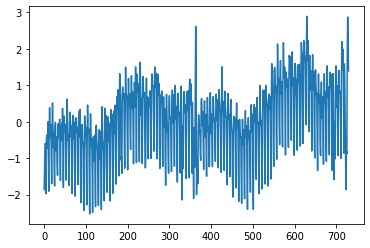

In [4]:
plt.plot(bd_sm["date_indexed"], bd_sm["births_normed"])

In [5]:
df = bd_sm

# define hyperparams
n_changepoints = 10
t = np.arange(len(df)) / len(df) # t in [0,1]
s = np.linspace(0, max(t), n_changepoints+2)[1:-1] # changepoints

A = (t[:, None] > s) * 1. # [:, None] adds second dimension to 1d array


n_components = 3
def X(t, p=365.25, n=3):
    x = 2 * np.pi * (np.arange(n)+1) * t[:, None] / p
    return np.concatenate((np.cos(x), np.sin(x)), axis=1)



with pm.Model() as model:
    # priors
    k = pm.Normal('k',0,1)
    m = pm.Normal('m',0,5)
    delta = pm.Laplace('delta',0,0.1, shape=n_changepoints)

    growth = k + tt.dot(A, delta)
    offset = m + tt.dot(A, -s * delta)
    trend = growth * t + offset

    beta = pm.Normal('beta', 0, 1, shape=n_components * 2) # coefficients (use laplacian for sparsity)
    seasonality = tt.dot(X(t, 365.25/len(t)), beta) # Fourier series with components

    prediction = trend + seasonality
    error = pm.HalfCauchy('sigma', 0.5)
    pm.Normal(
        'obs',
        prediction,
        error,
        observed=bd_sm["births_normed"][:200,None]
    )

    trace = pm.sample(tune=1000, chains=2)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '74609' (I am process '76406')
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, beta, delta, m, k]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 335 seconds.


In [ ]:
trend_df, plot_s = trend_component(t, np.mean(trace["delta"], axis=0),)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13d0038b0>,
      dtype=object)

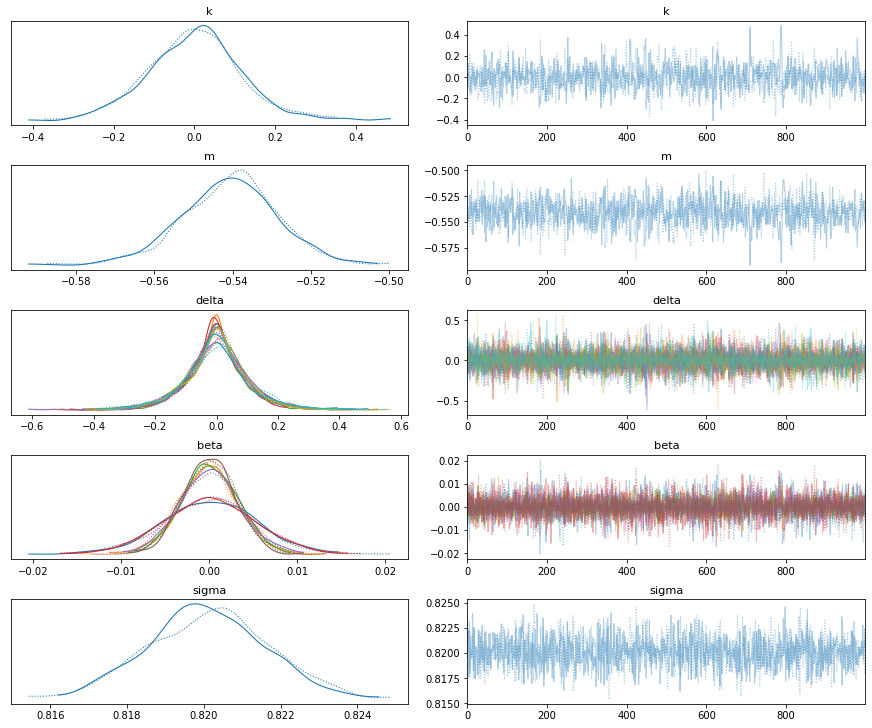

In [13]:
pm.traceplot(trace)

In [14]:
trend_df, plot_s = trend_component(t, np.mean(trace['delta'], axis=0))

NameError: name 'trend_component' is not defined